# Visualising Geographic Data with DataShader

Here I'll be playing with DataShader to visualise some geographic data.


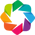

In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
import geoviews as gv

import xarray as xr
import holoviews as hv
import holoviews.operation.datashader as hd
import geoviews.feature as gf

import cartopy
from cartopy import crs as ccrs

import bokeh.plotting as bp
from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')

import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
auck_df = dd.read_csv("data/auck-street-address.csv")

In [5]:
def image_callback(x_range, y_range, w, h, name=None):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(auck_df, 'gd2000_xcoord', 'gd2000_ycoord')
    img = tf.shade(agg, cmap = ['lightblue', 'darkblue'], how='eq_hist')
    return tf.dynspread(img, threshold=0.50, name=name)

In [6]:
cvs = ds.Canvas(plot_width = 400, plot_height = 400)
agg = cvs.points(auck_df, 'gd2000_xcoord', 'gd2000_ycoord')
img = tf.shade(agg, cmap = ['lightblue', 'darkblue'], how='eq_hist')

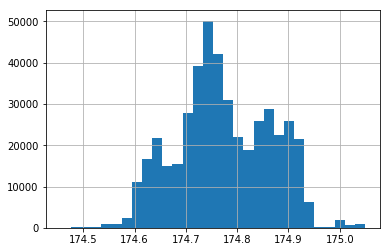

In [7]:
(auck_df
     .gd2000_xcoord
     .compute()
     .hist(bins = 30))

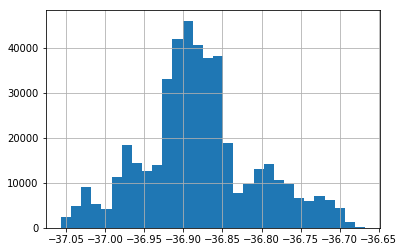

In [8]:
(auck_df
     .gd2000_ycoord
     .compute()
     .hist(bins = 30))


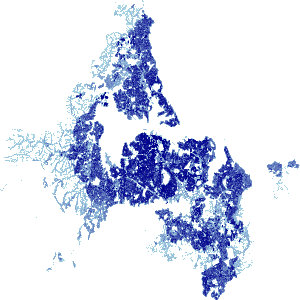
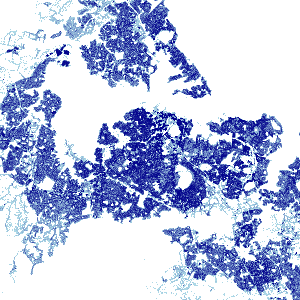
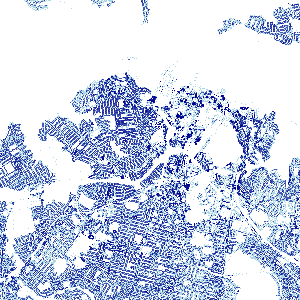

In [9]:
tf.Images(
    image_callback(None, None, 300, 300, name="Original"),
    image_callback((174.6, 174.9), (-37.00, -36.75), 300, 300, name="Zoom 1"),
    image_callback((174.7, 174.8), (-36.90, -36.82), 300, 300, name="Zoom 2"))

In [10]:
bp.output_notebook()
x_min = auck_df.gd2000_xcoord.min().compute()
x_max = auck_df.gd2000_xcoord.max().compute()
y_min = auck_df.gd2000_ycoord.min().compute()
y_max = auck_df.gd2000_ycoord.max().compute()

p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(x_min, x_max), 
              y_range=(y_min, y_max), plot_width=600, plot_height=500)

InteractiveImage(p, image_callback)

Loading BokehJS ...

In [24]:
url = 'http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'
tile_opts    = dict(width = 600, height = 500, 
#                     xaxis = None, 
#                     yaxis = None,
                    bgcolor = 'black', show_grid = False)
map_tiles    = (gv.WMTS(url)
                  .opts(style = dict(alpha = 0.8), plot = tile_opts))
points       = hv.Points(auck_df, ['gd2000_xcoord', 'gd2000_ycoord'])
address_plot = hd.datashade(
    points, 
    cmap = ['lightblue', 'darkblue']
)

In [28]:
map_tiles * address_plot

In [ ]:
dataset = gv.Dataset(df, kdims=['meterswest', 'metersnorth'], vdims=['race'])

tiles = gv.WMTS(WMTSTileSource(url=\
'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'))

color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange', 'o':'saddlebrown'}

tiles * datashade(dataset, x_sampling=10, y_sampling=10, cmap=color_key,
                  element_type=gv.Image, aggregator=ds.count_cat('race'))

In [35]:
dataset = gv.Dataset(auck_df, kdims=['gd2000_xcoord', 'gd2000_ycoord'])

tiles = gv.WMTS(WMTSTileSource(url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'))

# color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange', 'o':'saddlebrown'}

tiles * hd.datashade(dataset, cmap=['lightblue', 'darkblue'],
                  element_type=gv.Image, aggregator=ds.count())

:DynamicMap   []

In [13]:
tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
         'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
         'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
         'Stamen Toner': STAMEN_TONER}

In [22]:
om_wmts = WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')
gv.WMTS(om_wmts, extents=(0, -90, 360, 90), crs=ccrs.epsg("2193"))

:WMTS   [Longitude,Latitude]

In [4]:
%%opts WMTS [width=450 height=250 xaxis=None yaxis=None]
hv.NdLayout({name: gv.WMTS(wmts, extents=(0, -90, 360, 90), crs=ccrs.PlateCarree())
            for name, wmts in tiles.items()}, kdims=['Source']).cols(2)

:NdLayout   [Source]
   :WMTS   [Longitude,Latitude]

In [ ]:
https://stackoverflow.com/questions/35460295/how-do-i-plot-a-datashader-image-over-a-gmapplot-in-bokeh